# Project Progress Report 
## STAT 278
### Huan Liang and Julian Waugh

The first aspect of our group project focuses on analyzing whether the restaurant neighbors of a restaurant influence its probability of facing an unscheduled inspection. Specifically, if the neighbor restaurants faced many unscheduled inspections within the past month, will the restaurant face a higher probability of facing an unexpected inspection? Also, we want to find out whether the probability of an unexpected inspection is greater if the distinct restaurant underwent an unexpected inspection the past month. 

The second aspect of our group project focueses on analyzing whether vermin infestations of neighbor restaurants affect the probability of vermin infestations of the distinct restaurant, and whether the infestation status of the distinct restaurant in the previous month also affect the probability of infestation in the current month.

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix
from scipy.stats.distributions import chi2

#read the data
df = pd.read_csv("restaurant-scores-lives-standard.csv")

#get rid of guys without latitude and longitude
df = df.dropna(subset = ["business_latitude"])
df = df[df["business_latitude"] != 0]

#getting the neighborhoods
df1 = df.drop_duplicates(subset = "business_id")
df1 = df1[["business_id", "business_latitude", "business_longitude"]]


#clustering
km = KMeans(n_clusters = 10)
X = np.matrix(df1[["business_latitude", "business_longitude"]])
km.fit(X)
df1["cluster"] = km.labels_


#merge back to the original data set
df1 = df1[["business_id", "cluster"]]
df = df.merge(df1, on = "business_id")

#get a month and a year column
df["Year"] = df.inspection_date.str[:4]
df["Month"] = df.inspection_date.str[5:7]
df["Month"]= pd.to_numeric(df["Month"])

#create a year month column
#year goes from 2016 to 2019
yr = (pd.to_numeric(df["Year"]) - 2016) * 12
YearMonth = yr + df["Month"]
df["YearMonth"] = YearMonth

#choose a time/place
def get_neighborhood(year, cluster, df):
    Year = year
    cluster = cluster
    neighborhood = df[df["Year"] == Year]
    neighborhood = neighborhood[neighborhood["cluster"] == cluster]
    return neighborhood
#neighborhood is the df of a certain year and cluster

/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


After reading in our data set, we drop any rows that lack a latitude and longitude. Then, we divide the data into diffferent neighborhoods using the K- means algorithm. We do this in order to have smaller subsets that we can work with that are generated in a way where the signal is not lost. We use these smaller data sets to make computation faster and for data splitting. One question we had is if this is a proper way of doing data splitting, because restaurants are assigned to different neighborhoods based on their respective distances, and not randomly. We felt like this is the best way to split the data and preserve the "neighborhood" feel, but this still may be problematic.  We set number of neighborhoods to 10, ALTHOUGH THIS IS ARBITRARY AND WE NEED TO FIND A WAY TO FIND THE PERFECT NUMBER OF NEIGHBORHOODS. This seems like a selective inference problem, but we are not sure how to address it because we are not sure of methods other than data splitting to address selective inference in this setting, and we cannot split the data in a way that preserves the spatial relationship of restaurants without clustering them into neighborhoods.  

Finally, for the ease of working with a smaller subset of data, we sliced the data frame to only include the 6th cluster in 2017.

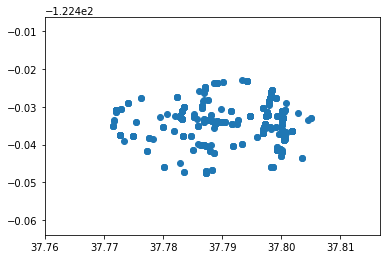

In [2]:
#plotting
neighborhood_2017 = get_neighborhood("2017", 6, df)
x = neighborhood_2017["business_latitude"]
y = neighborhood_2017["business_longitude"]

# centers = centroids[0]
# centers_x = centers[:,0]
# centers_y = centers[:, 1]



centers_2 = km.cluster_centers_
centers2_x = centers_2[:,0]
centers2_y = centers_2[:,1]


plt.figure()
plt.scatter(x,y)
#plt.scatter(centers_x, centers_y, c = "r", marker = "o")
#plt.scatter(centers2_x, centers2_y, c = "y", marker = "o")
plt.show()


Here, we plot all the restaurants in the 6th cluster in 2017.  

In [3]:
from sklearn.neighbors import NearestNeighbors

#make sure we know the index

def indicator(x):
    if x > 0:
        return(1)
    else:
        return(0)

def get_restaurant_data(rest_id, neighborhood, neighbors_count, rats_only = False,
                       random_neighbors = False):
    rest_df = neighborhood[neighborhood["business_id"] == rest_id]

    unique_neighborhood = neighborhood.drop_duplicates(subset = ["business_id"])
    X = np.matrix(unique_neighborhood[["business_latitude", "business_longitude"]])

    #get index of restaurant
    unique_neighborhood = unique_neighborhood.reset_index(drop=True)
    rest_index = unique_neighborhood.index[unique_neighborhood["business_id"] == rest_id].tolist()[0]
    
    if not random_neighbors:
        knn = NearestNeighbors(n_neighbors = neighbors_count)
        knn.fit(X)

        k_neighbors = knn.kneighbors(X[rest_index], return_distance = False)
        k_neighbors = k_neighbors[0][1:]

        neighbor_df = unique_neighborhood.iloc[k_neighbors]
        good_id = neighbor_df["business_id"]

        neighbor_df = neighborhood[neighborhood["business_id"].isin(good_id)]
    else:
        unique_neighborhood = unique_neighborhood.business_id.values
        unique_neighborhood = unique_neighborhood[unique_neighborhood != rest_index]
        good_id = np.random.choice(unique_neighborhood, neighbors_count, replace = False)
        neighbor_df = neighborhood[neighborhood["business_id"].isin(good_id)]

    #iterate through months
    all_data = []
    counter = 0
    for month in range(2,13):
        #vermin
        neighbors_last = neighbor_df[neighbor_df["Month"] == month - 1]
        neighbors_rat = neighbors_last[(neighbors_last["violation_description"] == "High risk vermin infestation") | (neighbors_last["violation_description"] == "Moderate risk vermin infestation") | (neighbors_last["violation_description"] == "Low risk vermin infestation")]
        rat_count_neighbors = neighbors_rat.shape[0]

        rest_last = rest_df[rest_df["Month"] == month - 1]
        rest_rat_last = rest_last[(rest_last["violation_description"] == "High risk vermin infestation") | (rest_last["violation_description"] == "Moderate risk vermin infestation") | (rest_last["violation_description"] == "Low risk vermin infestation")]
        rat_last = indicator(rest_rat_last.shape[0])

        rest_now = rest_df[rest_df["Month"] == month]
        rest_rat_now = rest_now[(rest_now["violation_description"] == "High risk vermin infestation") | (rest_now["violation_description"] == "Moderate risk vermin infestation") | (rest_now["violation_description"] == "Low risk vermin infestation")]
        rat_now = indicator(rest_rat_now.shape[0])
        
        
        #inspections
        if not rats_only:
            neighbors_inspections = neighbors_last[neighbors_last["inspection_type"] == "Routine - Unscheduled"]
            neighbors_inspections = neighbors_inspections.drop_duplicates(subset = "inspection_id")
            inspection_count_neighbors = neighbors_inspections.shape[0]

            inspection_rest_now = rest_now[rest_now["inspection_type"] == "Routine - Unscheduled"]
            inspection_now = indicator(inspection_rest_now.shape[0])

            inspection_rest_last = rest_last[rest_last["inspection_type"] == "Routine - Unscheduled"]
            inspection_last = indicator(inspection_rest_last.shape[0])
        
            if month == 2:
                if inspection_last == 1:
                    counter = 0

                else:
                    counter = 1
            counter += 1
        
        if not rats_only:
            data = [rat_count_neighbors, rat_last, rat_now, inspection_count_neighbors, counter, inspection_now, month]
        else:
            data = [rat_count_neighbors, rat_last, rat_now, month]
        
        if not rats_only:
            if inspection_now == 1:
                counter = 0
        all_data.append(data)
    return(all_data)


def generate_neighborhood_data(neighborhood, neighbors_count, save =True, scramble = True, 
                               rats_only = False, random_neighbors = False):

    ids = neighborhood.business_id.unique()
    #scramble months
    if scramble:
        y = np.random.permutation(neighborhood["Month"].values)
        neighborhood["Month"] = y
        save_str = "restaurant_data_scrambled.csv"


    else:
        save_str = "restaurant_data_unscrambled.csv"


    data = []
    for id in ids:
        rest_year = get_restaurant_data(id, neighborhood, neighbors_count, rats_only, random_neighbors)
        data += rest_year
    
    if not rats_only:
        columns = ["rat_count_neighbors", "rat_last", "rat_now", "inspection_count_neighbors", "time_since", "inspection_now", "month"]
    else:
         columns = ["rat_count_neighbors", "rat_last", "rat_now", "month"]
    mydata = pd.DataFrame(data, columns = columns)
    if save:
        mydata.to_csv(save_str)
    return(mydata)

When we are working within a neighborhood, we decide to focus only on the k nearest neighbors, as opposed to the whole neighborhood, because our neighborhood contains on the order of 100 restaurants, and we realistically think that restaurants only pay attention to what four or five of their neighbors do. For the inspections, we look just at months, and we count the time since the last inspection, and what the nearest 5 neighbors had happen in the last month. One goal we have is choosing k correctly. For the rats, we look at all types of rat violations, and we also permute the date column so we can do a permutation test that preserves the spatial relationship but loses the potential correlation between a restaurant's neighbors having rats in the past month and a restaurant having rats in the present.

Also, note that we are not doing any analysis in January so that we can look back to the past month for each month we analyze in 2017. 

In [4]:
# Create our scrambled and unscrambled data
unscrambled_2017 = generate_neighborhood_data(neighborhood_2017, 6, save = False, rats_only = True, scramble = False)

In [5]:
from scipy import stats
unscrambled = unscrambled_2017
no_rats = unscrambled[unscrambled["rat_now"] == 0]["rat_count_neighbors"].values
rats = unscrambled[unscrambled["rat_now"] == 1]["rat_count_neighbors"].values
F, p = stats.f_oneway(no_rats, rats)
p

0.07309709787851251

## Choosing K, Rats

To choose k for the k-n-n for the rats data, we decide to iterate through a range of ks, starting at k = 2 and finishing at k = 10. For each k, we run an anova test, where the groups are months where restaurants have rats vs not having rats. Then, each group is mapped to a vector indicating the counts of neighbors with rats in the last month. Running the ANOVA will let us determine if there is a statistically significant difference between the means of the groups - in other words, does having rats in the current month imply a major difference in the number of rats you had in the past month? If the answer is yes, then that could mean there is evidence of spatial and temporal clustering of rats, and that we should dig deeper to see if we can find evidence of clustering, maybe using the logistic regression coefficient test we previously developped.

Here, we find no p values that pass a Bonferroni Test. However, our results are still much better than in the past. Question: how should we choose k? Just take the smallest p value? Should we run the BH here?

In [12]:
#looping thru k_min to k_max where k is the number of neighbors
def get_anova(k_min, k_max, neighborhood, scrambled = False):
    d = {}
    for i in range(k_min,k_max+1):
        
        unscrambled_data = generate_neighborhood_data(neighborhood, i, save = False, scramble = False)
        if scrambled:
            scrambled_data = generate_neighborhood_data(neighborhood, i, save = False, scramble = True)
            no_rats = unscrambled_data[unscrambled_data["rat_now"] == 0]["rat_count_neighbors"].values
            rats = scrambled_data[scrambled_data["rat_now"] == 1]["rat_count_neighbors"].values
        else:   
            no_rats = unscrambled_data[unscrambled_data["rat_now"] == 0]["rat_count_neighbors"].values
            rats = unscrambled_data[unscrambled_data["rat_now"] == 1]["rat_count_neighbors"].values

        no_rat_sum = np.mean(no_rats)
        rat_sum = np.mean(rats)
        

        F, p = stats.f_oneway(no_rats, rats)
        d[i] = 1/p
        print(1/p)
        print(p)
    return d

    

In [13]:
#This is our dictionary where the key is the k in knn and the val is the p value
unscrambled_pvals = get_anova(2,10,neighborhood_2017)

1.2904553083280765
0.7749202886348753
11.686782771735444
0.08556674831147766
15.188182340240271
0.06584066332615417
7.779999788435536
0.12853470786547258
13.680433683728477
0.07309709787851251
7.912291560609633
0.12638563586033363
10.672557745028616
0.09369825152417752
5.8216848035590845
0.17177158052058236
4.70263353055707
0.2126468059869298


In [14]:
#This is the sum of the pvals, which gives us our statistic
unscrambled_sum = sum(unscrambled_pvals.values())
unscrambled_sum

78.73502153222219

In [ ]:
#Now, let's iterate N = 100 times and see how many scrambled sums are less than the unscrambled sum
scrambled_sums = []
for i in range(100):
    scrambled_pvals = get_anova(2, 10, neighborhood_2017, scrambled = True)
    scrambled_sum = sum(scrambled_pvals.values())
    scrambled_sums.append(scrambled_sum)
    print(str(i) + "is appended, yay!")


0.854337532141575
0.19230290539128217
0.002985038747320906
0.033523403922018385
0.5792475082230679
0.2324076800486189
0.028877632557008242
0.04896701264918944
0.805208620488614
0is appended, yay!
0.008840669523112537
0.9212185937221951
0.4995072118254914
0.00019952977042197783
0.019087252920921328
0.10998220081296574
0.15080031638373043
0.018910506977143235
0.7122873981609319
1is appended, yay!
0.8702231445738706
0.01048771180070757
0.4387030065050067
0.00012050036604849966
0.65009888933517
0.1241474128367268
0.01594951242132043
0.004154170138532324
0.2532762305796165
2is appended, yay!
0.8637227924344246
0.6156014233488212
0.002886076551160945
0.0009739192379063514
0.0006588231371573003
0.004413683012325059
0.1344630620367157
0.16007263511722172
0.023956306902431078
3is appended, yay!
0.9647707920291997
0.21747982864443904
0.014824067122610352
0.005728008724091296
0.10046476017524641
0.06967926827291683
0.22614867458387905
0.07396428003435264
0.37990782523787525
4is appended, yay!
0.9

## Inspection

### Prediction

NOTE: We did this with a fixed k = 6 in our k-N-N. We just chose that arbitrarily.


The first new thing we added was playing around with prediction for inspection. We built our model on 2016 data and tested on 2017 data. We decided to label a new point a "visit" if the probability was greater than 0.5. We then output a confusion matrix. We get a pretty high false positive rate. That being said, we also get a model that works most of the time, because our model generally tells us not to prepare for an inspection. I'm not sure how useful this is, but I wanted to output it just in case

In [ ]:
#generate 2016 data set
neighborhood_2016 = get_neighborhood("2016", 6, df)
unscrambled_2016 = generate_neighborhood_data(neighborhood_2016, 6, save = False, scramble = False)

In [19]:
#generate 2016 data set
neighborhood_2016 = get_neighborhood("2016", 6, df)
unscrambled_2016 = generate_neighborhood_data(neighborhood_2016, 6, save = False, scramble = False)

#build model, get testing data
mdl = logistic_inspection_model(unscrambled_2016)
test_dat = logistic_inspection_model(unscrambled_2017, False)

def predict(X,B):
    odds = np.dot(X,B)
    odds = np.exp(-1 * odds)
    rv = 1/(1+odds)
    return(rv)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.294309
         Iterations 8


array([[1425,  119],
       [  93,   57]])

In [28]:
X_test = np.array(test_dat['X'])
y_true = test_dat['y']['inspection_now'].values
B = mdl.params

y_hat = predict(X_test, B)
lambda_ = 0.55

y_pred = []

for y in y_hat:
    if y > lambda_:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_true)


array([[1456,  128],
       [  62,   48]])

In [48]:
 def logistic_inspection_model(unscrambled, regress = True, full = True):
    cat_vars = 'month'
    cat_list='var'+'_'+ cat_vars
    cat_list = pd.get_dummies(unscrambled[cat_vars], prefix = cat_vars)
    unscrambled1 = unscrambled.join(cat_list)
    unscrambled = unscrambled1
    unscrambled.columns
    nrow = unscrambled.shape[0]
    intercept = [1] * nrow
    unscrambled["intercept"] = intercept

    #index the x and y variables for inspection data
    if full:
        X_inspection = ['intercept', 'inspection_count_neighbors', 'time_since', 'month_3', 'month_4', 
                'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
    else:
        X_inspection = ['intercept', 'month_3', 'month_4',
                'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
    X_inspection = unscrambled[X_inspection]
    y_inspection = ['inspection_now']
    y_inspection = unscrambled[y_inspection]
    
    if regress:
        logit_model = sm.Logit(y_inspection, X_inspection)
        result_inspection=logit_model.fit(disp = 0)
        return(result_inspection)
    else:
        rv = {}
        rv['X'] = X_inspection
        rv['y'] = y_inspection
        return(rv)
        
    

## Inspection

### Choosing K
We choose k for our inspections analysis. To do this, we iterate through k = 2 to k = 10 in the k-N-N. For each k, we build a logistic regression model, and we then use a liklihood ratio test to compute a p value.

We find all of our p values to be extremely small. This is odd, because I do not know how to fix a value of k after finding this out. Should we compare to a model that is not the null model?


In [53]:
k_min = 2
k_max = 10


d = {}
for i in range(k_min,k_max+1):
    unscrambled_data = generate_neighborhood_data(neighborhood_2016, i, save = False, scramble = False)
    mdl = logistic_inspection_model(unscrambled_data)
    
    print(mdl.summary2())
    
    p = mdl.llr_pvalue
   
    d[i] = p
    
    
d


                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.213     
Dependent Variable:    inspection_now      AIC:                 987.3640  
Date:                  2019-03-18 11:42    BIC:                 1057.5004 
No. Observations:      1628                Log-Likelihood:      -480.68   
Df Model:              12                  LL-Null:             -610.46   
Df Residuals:          1615                LLR p-value:         1.3909e-48
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        8.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
intercept                  -5.0467   0.5916 -8.5312 0.0000 -6.2061 -3.8873
inspection_count_neighbors  0.2036   0.2695  0.7554 0.4

                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.219     
Dependent Variable:    inspection_now      AIC:                 979.8828  
Date:                  2019-03-18 11:43    BIC:                 1050.0192 
No. Observations:      1628                Log-Likelihood:      -476.94   
Df Model:              12                  LL-Null:             -610.46   
Df Residuals:          1615                LLR p-value:         3.8018e-50
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        8.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
intercept                  -5.0535   0.5915 -8.5429 0.0000 -6.2129 -3.8941
inspection_count_neighbors  0.2556   0.0892  2.8643 0.0

{2: 1.3908724268614045e-48,
 3: 4.211416753196072e-49,
 4: 6.696391736435984e-49,
 5: 3.2100171047102295e-49,
 6: 3.1392106965366765e-49,
 7: 3.801814967480687e-50,
 8: 1.4581168596085852e-50,
 9: 1.0404523505059525e-50,
 10: 4.27133667105807e-51}

In [ ]:
#writing a function to compute a liklihood ratio test between a model with only the
#seasonal predictors vs with the neighbors/ time since
from scipy.stats.distributions import chi2
#unscrambled_data = generate_neighborhood_data(neighborhood_2016, 5, save = False, scramble = False)
def LRT(mdl_full, mdl_small):
    #liklihood ratio test between two models
    LL_full = mdl_full.llf
    LL_small = mdl_small.llf
    LLR = 2* (LL_full - LL_small)
    p = chi2.sf(LLR, 2)
    return(p)


def test_inspection_models(data):
    #given restaurant data, this computes a liklihood ratio test between a model
    #with seasonal predictors and one without seasonal predictors
    mdl_full = logistic_inspection_model(data, full = True)
    mdl_small = logistic_inspection_model(data, full = False)
    p = LRT(mdl_full, mdl_small)
    return(p)


def search_ks(k_min, k_max, full_model_test, random_neighbors):
    #iterate through a range of k values and produce p values
    rv = []
    for i in range(k_min,k_max+1):
        data = generate_neighborhood_data(neighborhood_2016, i, 
                            save = False, scramble = False, random_neighbors = random_neighbors)

        if full_model_test:
            p = test_inspection_models(data)
        else:
            mdl = logistic_inspection_model(data)
            p = mdl.pvalues["inspection_count_neighbors"]


        rv.append(p)
    rv
    return(rv)

def get_p(truth, all_scrambled):
    # computes a p value for the matrix of p values
    p_true = np.sum(truth)
    all_scrambled = np.sum(all_scrambled, axis = 1)
    N = len(all_scrambled)
    
    smaller = all_scrambled[all_scrambled < p_true]
    return(len(smaller) / N)


k_min = 2
k_max = 10
full_model_test = False
random_neighbors = True
N = 100
all_scrambled = []

print(".....searching ks for truth .........")
truth = search_ks(k_min, k_max, True, False)
print(".....done, begininning permutation search..........")

for j in range(1, N+1):
        scrambled = search_ks(k_min, k_max, True, True)
        all_scrambled.append(scrambled)
        print(j/N)






.....searching ks for truth .........
.....done, begininning permutation search..........
0.01
0.02


In [79]:
mdl.pvalues["inspection_count_neighbors"]

0.0003356320291640128

# Progress Report 

After running the basic logistic regression for inspection, it is strange that every month has a negative coefficient. It is strange that all months are statistically significant and that all months have negative effects, meaning that whatever time of the year it is, the probability of an inspection is lower, which makes zero sense. However, it seems like it gets lower as the months go on, so maybe there is some trend here, like that restaurants get inspected more during the summer than the winter. Going forward, we might want to add an indicator for seasons instead of just for months. 

### Selective inference
One big problem that has come up that we think can solve is how to choose k in the k-n-n. We would appreciate any feedback that you can give us. What we were thinking of doing is as follows: first, we fix $\lambda \in [0,1]$ - a good starting choice we had is $\lambda$ = 0.5. If the probability returned by the regression model is > $\lambda$, then the we label that as a prediction of an inspection. Then, we calculate a false positive rate. We choose k by finding the value of k that minimizes the false positive rate on one neighborhood, then apply our model to another neighborhood to test it and draw conclusions, as a way of implementing data splitting to get rid of the inference problem of looking at the data to choose k. One way we could run the analysis "wrong" would be to draw conclusions from a model's p values that was trained on the same data set used to generate k. Please let us know if this is using enough "inference" and is not too machine learning-y, and if you have any suggestions on how we can do inference in this setting. 

### Rats

To analyze the clustering we use a permutation test. Our strategy is to compute $\beta$ from a logistic regression on the unscrambled data, then scramble the data and compute $\tilde{\beta_{j}}$ for j $\in$ {1,2,...,100}, then use these coefficients as a distribution to compute a p value. One conern is that we only do this 100 times, but our code is really slow, so this is the best we can do.

Also, this is a good to bring some other questions: we have subset the data to a neighborhood in 2017 to make the computation faster, but we might want to scale bigger. Do you recomend we look at all of the years or not? I feel as if that will make our code way too slow but is probably more accurate in terms of representing San Francisco. I think we would have a more accurate project, but we might not be able to do as many interesting things with inference. 

### Selective Inference

The same problem holds here that holds for the inspections: choosing k for k-n-n (note: we are having trouble thinking of other selective inference problems that are reasonable to tackle - we can't really deal with the time frame because if we went any smaller in terms of the window of time we are looking back when looking for rats in the neighborhood it be computationally infeasible and if we went larger we would lose any kind of relevance). We are thinking of choosing k by finding the k that has the smallest p value when running anova with the treatment groups being not having rats in a current month and having rats in the current month, and the effect data being the number of rats the neighbors had in the last month. Like with inspections, we could choose k "wrong" based on neighborhood 6, then compute a p value with the logistic regression technique, and we could choose k "right" by choosing it on another neighborhood that is not 6, then computing the p value with neighborhood 6 data.

### High level Summary of Questions

1) Are there parameters aside from k in k-n-n that we should be testing, and how should we be testing them?

2) For our tests of doing the analysis wrong and then doing the analysis right, we are only returning two numbers (p values) - can we make any really good conlcusions based on this or not?

3) Is our data splitting method valid?

4) Are there other technique/ parameters to test that make sense?

In [1]:
def get_rats_perm():
    scrambled = generate_neighborhood_data(neighborhood, save = False, scramble = True, rats_only = True)
    #cat_vars = 'month'
    #cat_list = 'var'+'_'+ cat_vars
    #cat_list = pd.get_dummies(scrambled[cat_vars], prefix = cat_vars)
    #scrambled1 = scrambled.join(cat_list)
    #scrambled = scrambled1
    nrow = scrambled.shape[0]
    intercept = [1] * nrow
    scrambled["intercept"] = intercept
 
    logreg = LogisticRegression()
    X_rat = ['intercept','rat_count_neighbors'] #'rat_last', 'month_2', 'month_3', 'month_4', 
                    #'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
    X_rat = scrambled[X_rat]
    y_rat = ['rat_now']
    y_rat = scrambled[y_rat]
    logit_model=sm.Logit(y_rat, X_rat)
    result_rat = logit_model.fit()
    return [result_rat.params.values.tolist()[1]]

        
   

# for i in range(5):
#     logreg = LogisticRegression()
#     unscrambled = generate_neighborhood_data(neighborhood, save = False, scramble = False)
#     X_rat = ['rat_count_neighbors', 'rat_last', 'month_2', 'month_3', 'month_4', 
#                     'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
#     X_rat = unscrambled[X_rat]
#     y_rat = ['rat_now']
#     y_rat = unscrambled[y_rat]
#     logit_model=sm.Logit(y_rat, X_rat)
#     result_rat = logit_model.fit()
#     rats_list.append(result_rat.params.values)


In [93]:
rats_list = [result_rat.params.values.tolist()[1]]
N_iter = 100
for i in range(N_iter):
    rats_params = get_rats_perm()
    rats_list += rats_params
    print((i +1) / N_iter)


#compute p values
B = rats_list[0]
L = len(rats_list) - 1
rats_list = np.array(rats_list[1:])


greater_list = rats_list > B

summ = 0
for x in greater_list:
    if x:
        summ += 1
        
print(summ/ L)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 0.072552
         Iterations 8
0.01
Optimization terminated successfully.
         Current function value: 0.066897
         Iterations 8
0.02
Optimization terminated successfully.
         Current function value: 0.076514
         Iterations 8
0.03
Optimization terminated successfully.
         Current function value: 0.076209
         Iterations 8
0.04
Optimization terminated successfully.
         Current function value: 0.075345
         Iterations 8
0.05
Optimization terminated successfully.
         Current function value: 0.069116
         Iterations 8
0.06
Optimization terminated successfully.
         Current function value: 0.072222
         Iterations 8
0.07
Optimization terminated successfully.
         Current function value: 0.074690
         Iterations 8
0.08
Optimization terminated successfully.
         Current function value: 0.074787
         Iterations 9
0.09
Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 0.070005
         Iterations 8
0.78
Optimization terminated successfully.
         Current function value: 0.066636
         Iterations 8
0.79
Optimization terminated successfully.
         Current function value: 0.074534
         Iterations 8
0.8
Optimization terminated successfully.
         Current function value: 0.075808
         Iterations 8
0.81
Optimization terminated successfully.
         Current function value: 0.075716
         Iterations 8
0.82
Optimization terminated successfully.
         Current function value: 0.073887
         Iterations 8
0.83
Optimization terminated successfully.
         Current function value: 0.070513
         Iterations 8
0.84
Optimization terminated successfully.
         Current function value: 0.071359
         Iterations 8
0.85
Optimization terminated successfully.
         Current function value: 0.069092
         Iterations 8
0.86
Optimization terminated successfully.


We get a p-value of 0.68 from our permutation tests. This could be inflated by the small sample size, but it is hard to do too many computations as they take a long time. Still, this is not promising for finding evidence of geographic clustering. 